In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import kagglehub
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, confusion_matrix
from datetime import datetime


# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
tf.random.set_seed(42)
np.random.seed(42)
# Download the ReducedMNIST dataset
path = kagglehub.dataset_download("mohamedgamal07/reduced-mnist")
print(f"Dataset downloaded to: {path}")

# List the files in the dataset
files = os.listdir(path)
print("Files in the dataset:", files)

path = path+"/Reduced MNIST Data"

train_dir = path +'/Reduced Trainging data'
test_dir = path+'/Reduced Testing data'


2025-04-24 20:03:16.693162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745517796.715488   90463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745517796.719788   90463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745517796.732653   90463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745517796.732670   90463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745517796.732672   90463 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset downloaded to: /home/youssef-abuzeid/.cache/kagglehub/datasets/mohamedgamal07/reduced-mnist/versions/1
Files in the dataset: ['Reduced MNIST Data']


In [2]:


# Function to load images from a directory
def load_images_from_directory(directory, n_samples_per_class=None):
    x_data, y_data = [], []
    for class_label in range(10):
        class_dir = os.path.join(directory, str(class_label))
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg'))]
        if n_samples_per_class:
            images = np.random.choice(images, n_samples_per_class, replace=False)
        for img_path in images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            img = img.astype('float32') / 255.0  # Normalize to [0, 1]
            x_data.append(img)
            y_data.append(class_label)
    x_data = np.array(x_data).reshape(-1, 28, 28, 1)  # Reshape for CNN
    y_data = np.array(y_data)
    return x_data, y_data

# Load training subsets
x_train_300, y_train_300 = load_images_from_directory(train_dir, n_samples_per_class=300)  # 30 per class = 300 total
x_train_700, y_train_700 = load_images_from_directory(train_dir, n_samples_per_class=700)  # 70 per class = 700 total
x_train_1000, y_train_1000 = load_images_from_directory(train_dir, n_samples_per_class=1000)  # 100 per class = 1000 total

# Load test set (200 samples total)
x_test, y_test = load_images_from_directory(test_dir, n_samples_per_class=200)  

I0000 00:00:1745517801.452945   90463 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 727 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


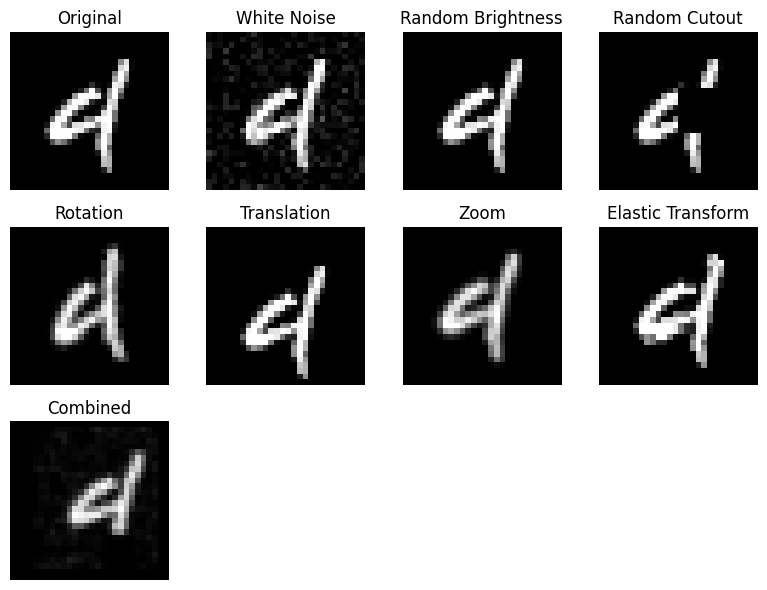

In [3]:

def add_white_noise(image, noise_factor=0.1):
    """Add Gaussian noise to an image.
    
    Args:
        image: A tensor image to add noise to
        noise_factor: Standard deviation of the noise
    
    Returns:
        Noisy image tensor
    """
    # Ensure image is a float tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Generate random noise with the same shape as the input image
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    
    # Add the noise to the image
    noisy_image = image + noise
    
    # Clip values to ensure they remain in the valid range [0,1]
    return tf.clip_by_value(noisy_image, 0.0, 1.0)

def random_brightness(image, max_delta=0.2):
    """Adjust brightness of an image.
    
    Args:
        image: A tensor image to adjust
        max_delta: Maximum brightness adjustment
    
    Returns:
        Brightness-adjusted image tensor
    """
    # Ensure image is a float tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Apply random brightness using TensorFlow's built-in function
    return tf.image.random_brightness(image, max_delta)

def random_cutout(image, size_range=(5, 8)):
    """Apply random cutout to an image.
    
    Args:
        image: A tensor image to apply cutout to
        size_range: Range of possible cutout sizes (min, max)
    
    Returns:
        Image tensor with random cutout
    """
    # Ensure image is a float tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Get image dimensions
    if len(image.shape) == 2:
        h, w = image.shape
        channels = 1
    else:
        h, w, channels = image.shape
    
    # Get a random cutout size
    size = np.random.randint(size_range[0], size_range[1] + 1)
    
    # Get random positions for the cutout
    x = np.random.randint(0, w - size + 1)
    y = np.random.randint(0, h - size + 1)
    
    # Create the cutout
    cutout = np.ones((h, w), dtype=np.float32)
    cutout[y:y+size, x:x+size] = 0.0
    
    # Apply the cutout to the image
    if channels > 1:
        cutout = np.expand_dims(cutout, axis=-1)
    
    return image * cutout

def rotate_image_np(image, max_angle=25):
    """Rotate image using NumPy.
    
    Args:
        image: A numpy array image to rotate
        max_angle: Maximum rotation angle in degrees
    
    Returns:
        Rotated image as numpy array
    """
    # Ensure we have a numpy array
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Generate a random angle
    angle = np.random.uniform(-max_angle, max_angle)
    
    # Convert to PIL Image for rotation
    from PIL import Image
    if len(image.shape) == 2:
        pil_image = Image.fromarray((image * 255).astype(np.uint8), mode='L')
    else:
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
    
    # Rotate and convert back to numpy array
    rotated = pil_image.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
    result = np.array(rotated, dtype=np.float32) / 255.0
    
    return result

def translate_image_np(image, max_shift=4):
    """Translate image using NumPy.
    
    Args:
        image: A numpy array image to translate
        max_shift: Maximum pixel shift
    
    Returns:
        Translated image as numpy array
    """
    # Ensure we have a numpy array
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Generate random shifts
    dx = np.random.randint(-max_shift, max_shift + 1)
    dy = np.random.randint(-max_shift, max_shift + 1)
    
    # Get image dimensions
    if len(image.shape) == 2:
        h, w = image.shape
        result = np.zeros_like(image)
    else:
        h, w, c = image.shape
        result = np.zeros_like(image)
    
    # Calculate source and destination rectangles
    src_x = max(0, dx) if dx < 0 else 0
    src_y = max(0, dy) if dy < 0 else 0
    src_w = w - abs(dx) if dx < 0 else w - dx
    src_h = h - abs(dy) if dy < 0 else h - dy
    
    dst_x = 0 if dx < 0 else dx
    dst_y = 0 if dy < 0 else dy
    
    # Copy the valid region
    if len(image.shape) == 2:
        result[dst_y:dst_y+src_h, dst_x:dst_x+src_w] = image[src_y:src_y+src_h, src_x:src_x+src_w]
    else:
        result[dst_y:dst_y+src_h, dst_x:dst_x+src_w, :] = image[src_y:src_y+src_h, src_x:src_x+src_w, :]
    
    return result

def zoom_image_np(image, zoom_range=0.15):
    """Zoom image using NumPy.
    
    Args:
        image: A numpy array image to zoom
        zoom_range: Maximum zoom factor
    
    Returns:
        Zoomed image as numpy array
    """
    # Ensure we have a numpy array
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Generate random zoom factor
    zoom = np.random.uniform(1.0 - zoom_range, 1.0 + zoom_range)
    
    # Convert to PIL Image for zooming
    from PIL import Image
    if len(image.shape) == 2:
        pil_image = Image.fromarray((image * 255).astype(np.uint8), mode='L')
    else:
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
    
    # Get original dimensions
    h, w = pil_image.size
    
    # Calculate new dimensions
    new_h = int(h * zoom)
    new_w = int(w * zoom)
    
    # Resize
    zoomed = pil_image.resize((new_h, new_w), resample=Image.BILINEAR)
    
    # Crop or pad to original size
    left = (new_w - w) // 2
    top = (new_h - h) // 2
    right = left + w
    bottom = top + h
    
    if zoom > 1.0:  # Image is larger, crop
        zoomed = zoomed.crop((left, top, right, bottom))
    else:  # Image is smaller, pad with black
        result = Image.new(pil_image.mode, (w, h), color=0)
        paste_left = (w - new_w) // 2
        paste_top = (h - new_h) // 2
        result.paste(zoomed, (paste_left, paste_top))
        zoomed = result
    
    # Convert back to numpy array
    result = np.array(zoomed, dtype=np.float32) / 255.0
    
    return result

def elastic_transform_np(image, alpha=8, sigma=3):
    """Apply elastic transform using NumPy.
    
    Args:
        image: A numpy array image to transform
        alpha: Deformation strength
        sigma: Deformation smoothness
    
    Returns:
        Transformed image as numpy array
    """
    # Ensure we have a numpy array
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Function to generate random displacement fields
    def generate_displacement_fields(shape, alpha, sigma):
        from scipy.ndimage import gaussian_filter
        dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
        return dx, dy
    
    # Generate random displacement fields
    shape = image.shape[:2]
    dx, dy = generate_displacement_fields(shape, alpha, sigma)
    
    # Create meshgrid for mapping coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Apply displacement
    indices_x = np.clip(x + dx, 0, shape[1] - 1).astype(np.float32)
    indices_y = np.clip(y + dy, 0, shape[0] - 1).astype(np.float32)
    
    # Use PIL for the final transformation
    from PIL import Image
    if len(image.shape) == 2:
        pil_image = Image.fromarray((image * 255).astype(np.uint8), mode='L')
    else:
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
    
    # Create output image
    distorted = np.zeros_like(image)
    
    # Simple version: approximation by nearest neighbor sampling
    indices_x = indices_x.astype(np.int32)
    indices_y = indices_y.astype(np.int32)
    
    # Apply mapping
    if len(image.shape) == 2:
        for i in range(shape[0]):
            for j in range(shape[1]):
                distorted[i, j] = image[indices_y[i, j], indices_x[i, j]]
    else:
        for i in range(shape[0]):
            for j in range(shape[1]):
                distorted[i, j, :] = image[indices_y[i, j], indices_x[i, j], :]
    
    return distorted

def augment_image(image, augmentation_strength=0.1):
    """Apply multiple augmentations to an image.
    
    Args:
        image: A tensor or numpy array image to augment
        augmentation_strength: Float controlling overall intensity (0.0-1.0)
    
    Returns:
        Augmented image
    """
    # Convert to numpy for processing
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Apply augmentations with probability based on strength
    augmentations = [
        # (augmentation_function, probability)
        (add_white_noise, 0.5 * augmentation_strength, {'noise_factor': 0.08}),
        (random_brightness, 0.5 * augmentation_strength, {'max_delta': 0.15}),
        (random_cutout, 0.5 * augmentation_strength, {'size_range': (5, 8)}),
        (rotate_image_np, 0.5 * augmentation_strength, {'max_angle': 25}),
        (translate_image_np, 0.5 * augmentation_strength, {'max_shift': 4}),
        (zoom_image_np, 0.5 * augmentation_strength, {'zoom_range': 0.15}),
        (elastic_transform_np, 0.3 * augmentation_strength, {'alpha': 10, 'sigma': 3})
    ]
    
    # Apply TensorFlow augmentations first
    result = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Apply TensorFlow augmentations
    for i in range(3):  # First 3 are TensorFlow functions
        aug_fn, probability, kwargs = augmentations[i]
        if np.random.random() < probability:
            result = aug_fn(result, **kwargs)
    
    # Convert to numpy for the rest of augmentations
    result = result.numpy() if isinstance(result, tf.Tensor) else result
    
    # Apply NumPy-based augmentations
    for i in range(3, len(augmentations)):
        aug_fn, probability, kwargs = augmentations[i]
        if np.random.random() < probability:
            result = aug_fn(result, **kwargs)
    
    # Return as tensor
    return tf.convert_to_tensor(result, dtype=tf.float32)
def augment_image(image, augmentation_strength=1.0):
    """Apply multiple augmentations to an image.
    
    Args:
        image: A tensor or numpy array image to augment
        augmentation_strength: Float controlling overall intensity (0.0-1.0)
    
    Returns:
        Augmented image
    """
    # Convert to numpy for processing
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Ensure proper shape for processing - we want (height, width, channels)
    if len(image.shape) == 2:  # If it's (28, 28)
        image = np.expand_dims(image, axis=-1)  # Make it (28, 28, 1)
    
    # Fix problematic shapes
    if image.shape[2] > 10 or image.shape[0] == 1 and image.shape[1] == 1:
        # Handle cases where dimensions are swapped or flattened
        image = np.reshape(image, (28, 28, 1))  # Force reshape to expected MNIST shape
    
    # Ensure image is normalized float32
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    if image.max() > 1.0:
        image = image / 255.0
    
    # Start with a copy of the original image
    result = image.copy()
    
    # Apply augmentations with probability based on strength
    
    # 1. Add white noise
    if np.random.random() < 0.7 * augmentation_strength:
        noise_factor = 0.08
        noise = np.random.normal(0, noise_factor, result.shape)
        result = np.clip(result + noise, 0.0, 1.0)
    
    # 2. Random brightness
    if np.random.random() < 0.7 * augmentation_strength:
        max_delta = 0.15
        delta = np.random.uniform(-max_delta, max_delta)
        result = np.clip(result + delta, 0.0, 1.0)
    
    # 3. Random cutout
    if np.random.random() < 0.5 * augmentation_strength:
        h, w, c = result.shape
        size = np.random.randint(5, 9)  # Size between 5-8
        x = np.random.randint(0, w - size + 1)
        y = np.random.randint(0, h - size + 1)
        result[y:y+size, x:x+size, :] = 0.0
    
    # 4. Rotation
    if np.random.random() < 0.7 * augmentation_strength:
        angle = np.random.uniform(-25, 25)
        from PIL import Image
        # Convert to PIL Image for rotation (remove channel dimension)
        pil_img = Image.fromarray((result.squeeze() * 255).astype(np.uint8), mode='L')
        rotated = pil_img.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
        # Convert back to numpy and restore channel dimension
        result = np.expand_dims(np.array(rotated, dtype=np.float32) / 255.0, axis=-1)
    
    # 5. Translation
    if np.random.random() < 0.7 * augmentation_strength:
        max_shift = 4
        dx = np.random.randint(-max_shift, max_shift + 1)
        dy = np.random.randint(-max_shift, max_shift + 1)
        h, w, c = result.shape
        shifted = np.zeros_like(result)
        
        # Source and destination regions
        src_x = max(0, dx) if dx < 0 else 0
        src_y = max(0, dy) if dy < 0 else 0
        src_w = w - abs(dx) if dx < 0 else w - dx
        src_h = h - abs(dy) if dy < 0 else h - dy
        
        dst_x = 0 if dx < 0 else dx
        dst_y = 0 if dy < 0 else dy
        
        shifted[dst_y:dst_y+src_h, dst_x:dst_x+src_w, :] = result[src_y:src_y+src_h, src_x:src_x+src_w, :]
        result = shifted
    
    # 6. Zoom
    if np.random.random() < 0.5 * augmentation_strength:
        zoom_range = 0.15
        zoom = np.random.uniform(1.0 - zoom_range, 1.0 + zoom_range)
        
        from PIL import Image
        h, w, c = result.shape
        
        # Convert to PIL Image
        pil_img = Image.fromarray((result.squeeze() * 255).astype(np.uint8), mode='L')
        
        # Calculate new dimensions
        new_h = int(h * zoom)
        new_w = int(w * zoom)
        
        # Resize
        zoomed = pil_img.resize((new_w, new_h), resample=Image.BILINEAR)
        
        # Create output image (start with zeros)
        final_img = Image.new('L', (w, h), color=0)
        
        if zoom > 1.0:  # Image is larger, crop center
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            zoomed = zoomed.crop((left, top, left + w, top + h))
            final_img = zoomed
        else:  # Image is smaller, pad with black
            paste_left = (w - new_w) // 2
            paste_top = (h - new_h) // 2
            final_img.paste(zoomed, (paste_left, paste_top))
        
        # Convert back to numpy with channel dimension
        result = np.expand_dims(np.array(final_img, dtype=np.float32) / 255.0, axis=-1)
    
    # 7. Elastic transform (simplified version)
    if np.random.random() < 0.3 * augmentation_strength:
        alpha = 10.0  # Deformation strength
        sigma = 3.0    # Deformation smoothness
        
        # Generate random displacement fields
        h, w, c = result.shape
        from scipy.ndimage import gaussian_filter
        
        # Create random displacement fields
        dx = gaussian_filter((np.random.rand(h, w) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((np.random.rand(h, w) * 2 - 1), sigma) * alpha
        
        # Create meshgrid for mapping coordinates
        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        
        # Apply displacement with bounds checking
        indices_x = np.clip(x + dx, 0, w - 1).astype(np.int32)
        indices_y = np.clip(y + dy, 0, h - 1).astype(np.int32)
        
        # Apply mapping (simplified version using integer indices)
        distorted = np.zeros_like(result)
        for i in range(h):
            for j in range(w):
                distorted[i, j] = result[indices_y[i, j], indices_x[i, j]]
        
        result = distorted
    
    # Ensure output has correct shape and type
    if result.shape != (28, 28, 1):
        result = np.reshape(result, (28, 28, 1))
    
    # Return as tensor
    return tf.convert_to_tensor(result, dtype=tf.float32)

# Visualization function
def visualize_augmentations(image):
    """Visualize different augmentations applied to an image, each applied once, in a 4-column grid.
    
    Args:
        image: Original image to augment
    """
    # Define augmentation functions to visualize
    augmentations = [
        ("Original", lambda x: x),
        ("White Noise", lambda x: add_white_noise(x)),
        ("Random Brightness", lambda x: random_brightness(x)),
        ("Random Cutout", lambda x: random_cutout(x)),
        ("Rotation", lambda x: rotate_image_np(x)),
        ("Translation", lambda x: translate_image_np(x)),
        ("Zoom", lambda x: zoom_image_np(x)),
        ("Elastic Transform", lambda x: elastic_transform_np(x)),
        ("Combined", lambda x: augment_image(x, augmentation_strength=1))
    ]
    
    # Apply each augmentation once
    augmented_images = []
    for name, aug_fn in augmentations:
        try:
            augmented = aug_fn(image)
            if isinstance(augmented, tf.Tensor):
                augmented = augmented.numpy()
            augmented_images.append((name, augmented))
        except Exception as e:
            print(f"Error in {name}: {e}")
            augmented_images.append((name, np.zeros_like(image)))
    
    # Determine grid size
    num_images = len(augmented_images)  # Total images: original + 8 augmentations = 9
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division: 9 / 4 = 3 rows
    
    # Create figure
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    
    # Plot each image with its title
    for i, (name, img) in enumerate(augmented_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Load and visualize a sample MNIST image
def load_and_visualize_mnist():
    """Load MNIST dataset and visualize augmentations on a sample image."""
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    
    # Normalize to [0,1]
    x_train = x_train.astype('float32') / 255.0
    
    # Select a random image
    idx = np.random.randint(0, len(x_train))
    sample_image = x_train[idx]
    
    # Visualize augmentations
    visualize_augmentations(sample_image)

load_and_visualize_mnist()

In [10]:
def generate_dataset_with_augmentation(images, labels, num_real, num_generated):
    """Generate an augmented dataset combining real and synthetic images.
    
    Args:
        images: Tensor of input images
        labels: Tensor of input labels
        num_real: Number of real samples to use
        num_generated: Total number of generated samples to create
    
    Returns:
        Tuple of (all_images, all_labels) containing combined dataset
    """
    # Subsample real images
    real_images = images[:num_real]
    real_labels = labels[:num_real]

    if num_generated == 0:
        return real_images, real_labels

    # Calculate samples per class
    num_classes = 10  # For MNIST
    samples_per_class = num_generated // num_classes
    
    synthetic_images = []
    synthetic_labels = []

    # Generate augmented data per class to maintain class balance
    for class_idx in range(num_classes):
        # Find all images of this class
        class_indices = tf.where(tf.equal(real_labels, class_idx))[:, 0]
        if len(class_indices) == 0:
            print(f"Warning: No samples found for class {class_idx}")
            continue
            
        class_images = tf.gather(real_images, class_indices)
        print(f"Class {class_idx}: found {len(class_images)} images")
        
        # Generate augmented samples for this class
        augmented_count = 0
        max_attempts = samples_per_class * 2  # Allow for some failures
        attempts = 0
        
        while augmented_count < samples_per_class and attempts < max_attempts:
            # Randomly select an image from this class to augment
            img_idx = np.random.randint(0, len(class_images))
            img = class_images[img_idx]
            
            try:
                # Apply augmentation
                aug_img = augment_image(img, augmentation_strength=0.3)
                synthetic_images.append(aug_img)
                synthetic_labels.append(class_idx)
                augmented_count += 1
            except Exception as e:
                print(f"Error augmenting class {class_idx} image {img_idx}: {e}")
            
            attempts += 1
        
        print(f"Generated {augmented_count}/{samples_per_class} augmented images for class {class_idx}")

    # Check if we generated any augmented images
    if len(synthetic_images) == 0:
        print("Warning: No images could be augmented. Returning only real images.")
        return real_images, real_labels

    # Convert lists to tensors
    synthetic_images = tf.stack(synthetic_images)
    synthetic_labels = tf.convert_to_tensor(synthetic_labels)
    
    print(f"Total synthetic images: {len(synthetic_images)}")

    # Combine real and generated data
    all_images = tf.concat([real_images, synthetic_images], axis=0)
    all_labels = tf.concat([real_labels, synthetic_labels], axis=0)
    
    # Shuffle the combined dataset
    indices = tf.range(start=0, limit=tf.shape(all_images)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    all_images = tf.gather(all_images, shuffled_indices)
    all_labels = tf.gather(all_labels, shuffled_indices)
    
    print(f"Final dataset: {len(all_images)} images ({num_real} real + {len(synthetic_images)} synthetic)")
    
    return all_images, all_labels

## Classifier Architecture

In [11]:
def create_cnn_model():
    """Create a simple CNN model for digit classification"""
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Train the models

In [12]:
def log_message(message):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

In [13]:
# Step 1: Load real and test data
log_message("Starting experiment pipeline for Problem 2")
log_message("Loading real training data")
x_train_300, y_train_300 = load_images_from_directory(train_dir, n_samples_per_class=300)  # 300 per class
x_train_700, y_train_700 = load_images_from_directory(train_dir, n_samples_per_class=700)  # 700 per class
x_train_1000, y_train_1000 = load_images_from_directory(train_dir, n_samples_per_class=1000)  # 1000 per class
log_message(f"Training data shape: {x_train_300.shape}")
log_message("Loading test data")
x_test, y_test = load_images_from_directory(test_dir, n_samples_per_class=200)  # 200 per class
log_message(f"Test data shape: x_test={x_test.shape}, y_test={y_test.shape}")

# Step 2: Define the results table
results_table = {
    300: {0: 0, 10000: 0, 20000: 0, 30000: 0},
    700: {0: 0, 10000: 0, 20000: 0, 30000: 0},
    1000: {0: 0, 10000: 0, 20000: 0, 30000: 0}
}

# Step 3: Run experiments for each combination
for real_samples, x_train, y_train in [(300, x_train_300, y_train_300), 
                                       (700, x_train_700, y_train_700), 
                                       (1000, x_train_1000, y_train_1000)]:
    log_message(f"Starting experiments for {real_samples} real samples")
    for generated_samples in [0, 1000, 2000, 3000]:
        log_message(f"Experiment: {real_samples} real + {generated_samples} generated")
        
        # Step 3.1: Generate augmented dataset
        total_samples = real_samples + generated_samples
        if generated_samples == 0:
            x_train_combined, y_train_combined = x_train, y_train
            log_message("Using only real data, no augmentation")
        else:
            try:
                x_train_combined, y_train_combined = generate_dataset_with_augmentation(
                    x_train, y_train, real_samples*10, generated_samples*10
                ) # Generate 1000,2000,3000 per class
            except Exception as e:
                log_message(f"Error during augmentation: {str(e)}")
                continue
        
        # Step 3.2: Create and train the model
        try:
            model = create_cnn_model()
            log_message("Training model")
            history = model.fit(
                x_train_combined, y_train_combined, 
                epochs=20, batch_size=32, verbose=0,
                
            )
        except Exception as e:
            log_message(f"Error during training: {str(e)}")
            continue
        
        # Step 3.3: Evaluate on the test set
        log_message("Evaluating model on test set")
        pred = model.predict(x_test)
        y_pred = np.argmax(pred, axis=1)
        test_accuracy = accuracy_score(y_test, y_pred)
        log_message(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Step 3.4: Store the result
        results_table[real_samples][generated_samples] = test_accuracy
        log_message(f"Stored result: Real: {real_samples}, Generated: {generated_samples}, Test Accuracy: {test_accuracy:.4f}")

# Step 4: Display the results table
log_message("Test Accuracies Table:")
print("| Real Samples | 0 Generated | 1000 Generated | 2000 Generated | 3000 Generated |")
print("|--------------|-------------|----------------|----------------|----------------|")
for real_samples in [300, 700, 1000]:
    row = f"| {real_samples:<12} | {results_table[real_samples][0]:.4f}       | {results_table[real_samples][1000]:.4f}         | {results_table[real_samples][2000]:.4f}         | {results_table[real_samples][3000]:.4f}         |"
    print(row)

[2025-04-24 14:38:36] Starting experiment pipeline for Problem 2
[2025-04-24 14:38:36] Loading real training data
[2025-04-24 14:38:37] Training data shape: (3000, 28, 28, 1)
[2025-04-24 14:38:37] Loading test data
[2025-04-24 14:38:37] Test data shape: x_test=(2000, 28, 28, 1), y_test=(2000,)
[2025-04-24 14:38:37] Starting experiments for 300 real samples
[2025-04-24 14:38:37] Experiment: 300 real + 0 generated
[2025-04-24 14:38:37] Using only real data, no augmentation
[2025-04-24 14:38:37] Training model
[2025-04-24 14:38:45] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:38:46] Test Accuracy: 0.9795
[2025-04-24 14:38:46] Stored result: Real: 300, Generated: 0, Test Accuracy: 0.9795
[2025-04-24 14:38:46] Experiment: 300 real + 1000 generated
Class 0: found 300 images
Generated 1000/1000 augmented images for class 0
Class 1: found 300 images
Generated 1000/1000 augmented images for class 1
Class 2: found 300 images
Generated 1000/1000 augmented ima

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:39:18] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[2025-04-24 14:39:19] Test Accuracy: 0.9835
[2025-04-24 14:39:19] Stored result: Real: 300, Generated: 1000, Test Accuracy: 0.9835
[2025-04-24 14:39:19] Experiment: 300 real + 2000 generated
Class 0: found 300 images
Generated 2000/2000 augmented images for class 0
Class 1: found 300 images
Generated 2000/2000 augmented images for class 1
Class 2: found 300 images
Generated 2000/2000 augmented images for class 2
Class 3: found 300 images
Generated 2000/2000 augmented images for class 3
Class 4: found 300 images
Generated 2000/2000 augmented images for class 4
Class 5: found 300 images
Generated 2000/2000 augmented images for class 5
Class 6: found 300 images
Generated 2000/2000 augmented images for class 6
Class 7: found 300 images
Generated 2000/2000 augmented images for class 7
Class 8: found 300 images
Generated 2000/2000 augmented images for class 8
Class 9: found 300 images
Generated 2000/200

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:40:11] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[2025-04-24 14:40:12] Test Accuracy: 0.9855
[2025-04-24 14:40:12] Stored result: Real: 300, Generated: 2000, Test Accuracy: 0.9855
[2025-04-24 14:40:12] Experiment: 300 real + 3000 generated
Class 0: found 300 images
Generated 3000/3000 augmented images for class 0
Class 1: found 300 images
Generated 3000/3000 augmented images for class 1
Class 2: found 300 images
Generated 3000/3000 augmented images for class 2
Class 3: found 300 images
Generated 3000/3000 augmented images for class 3
Class 4: found 300 images
Generated 3000/3000 augmented images for class 4
Class 5: found 300 images
Generated 3000/3000 augmented images for class 5
Class 6: found 300 images
Generated 3000/3000 augmented images for class 6
Class 7: found 300 images
Generated 3000/3000 augmented images for class 7
Class 8: found 300 images
Generated 3000/3000 augmented images for class 8
Class 9: found 300 images
Generated 3000/300

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:41:25] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[2025-04-24 14:41:26] Test Accuracy: 0.9865
[2025-04-24 14:41:26] Stored result: Real: 300, Generated: 3000, Test Accuracy: 0.9865
[2025-04-24 14:41:26] Starting experiments for 700 real samples
[2025-04-24 14:41:26] Experiment: 700 real + 0 generated
[2025-04-24 14:41:26] Using only real data, no augmentation
[2025-04-24 14:41:26] Training model


/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:41:41] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:41:42] Test Accuracy: 0.9860
[2025-04-24 14:41:42] Stored result: Real: 700, Generated: 0, Test Accuracy: 0.9860
[2025-04-24 14:41:42] Experiment: 700 real + 1000 generated
Class 0: found 700 images
Generated 1000/1000 augmented images for class 0
Class 1: found 700 images
Generated 1000/1000 augmented images for class 1
Class 2: found 700 images
Generated 1000/1000 augmented images for class 2
Class 3: found 700 images
Generated 1000/1000 augmented images for class 3
Class 4: found 700 images
Generated 1000/1000 augmented images for class 4
Class 5: found 700 images
Generated 1000/1000 augmented images for class 5
Class 6: found 700 images
Generated 1000/1000 augmented images for class 6
Class 7: found 700 images
Generated 1000/1000 augmented images for class 7
Class 8: found 700 images
Generated 1000/1000 augmented images for class 8
Class 9: found 700 images
Generated 1000/1000 a

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:42:18] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[2025-04-24 14:42:19] Test Accuracy: 0.9855
[2025-04-24 14:42:19] Stored result: Real: 700, Generated: 1000, Test Accuracy: 0.9855
[2025-04-24 14:42:19] Experiment: 700 real + 2000 generated
Class 0: found 700 images
Generated 2000/2000 augmented images for class 0
Class 1: found 700 images
Generated 2000/2000 augmented images for class 1
Class 2: found 700 images
Generated 2000/2000 augmented images for class 2
Class 3: found 700 images
Generated 2000/2000 augmented images for class 3
Class 4: found 700 images
Generated 2000/2000 augmented images for class 4
Class 5: found 700 images
Generated 2000/2000 augmented images for class 5
Class 6: found 700 images
Generated 2000/2000 augmented images for class 6
Class 7: found 700 images
Generated 2000/2000 augmented images for class 7
Class 8: found 700 images
Generated 2000/2000 augmented images for class 8
Class 9: found 700 images
Generated 2000/200

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:43:09] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[2025-04-24 14:43:10] Test Accuracy: 0.9890
[2025-04-24 14:43:10] Stored result: Real: 700, Generated: 2000, Test Accuracy: 0.9890
[2025-04-24 14:43:10] Experiment: 700 real + 3000 generated
Class 0: found 700 images
Generated 3000/3000 augmented images for class 0
Class 1: found 700 images
Generated 3000/3000 augmented images for class 1
Class 2: found 700 images
Generated 3000/3000 augmented images for class 2
Class 3: found 700 images
Generated 3000/3000 augmented images for class 3
Class 4: found 700 images
Generated 3000/3000 augmented images for class 4
Class 5: found 700 images
Generated 3000/3000 augmented images for class 5
Class 6: found 700 images
Generated 3000/3000 augmented images for class 6
Class 7: found 700 images
Generated 3000/3000 augmented images for class 7
Class 8: found 700 images
Generated 3000/3000 augmented images for class 8
Class 9: found 700 images
Generated 3000/300

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:44:18] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[2025-04-24 14:44:18] Test Accuracy: 0.9875
[2025-04-24 14:44:18] Stored result: Real: 700, Generated: 3000, Test Accuracy: 0.9875
[2025-04-24 14:44:18] Starting experiments for 1000 real samples
[2025-04-24 14:44:18] Experiment: 1000 real + 0 generated
[2025-04-24 14:44:18] Using only real data, no augmentation
[2025-04-24 14:44:18] Training model


/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:44:35] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:44:36] Test Accuracy: 0.9885
[2025-04-24 14:44:36] Stored result: Real: 1000, Generated: 0, Test Accuracy: 0.9885
[2025-04-24 14:44:36] Experiment: 1000 real + 1000 generated
Class 0: found 1000 images
Generated 1000/1000 augmented images for class 0
Class 1: found 1000 images
Generated 1000/1000 augmented images for class 1
Class 2: found 1000 images
Generated 1000/1000 augmented images for class 2
Class 3: found 1000 images
Generated 1000/1000 augmented images for class 3
Class 4: found 1000 images
Generated 1000/1000 augmented images for class 4
Class 5: found 1000 images
Generated 1000/1000 augmented images for class 5
Class 6: found 1000 images
Generated 1000/1000 augmented images for class 6
Class 7: found 1000 images
Generated 1000/1000 augmented images for class 7
Class 8: found 1000 images
Generated 1000/1000 augmented images for class 8
Class 9: found 1000 images
Generated

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:45:15] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:45:16] Test Accuracy: 0.9895
[2025-04-24 14:45:16] Stored result: Real: 1000, Generated: 1000, Test Accuracy: 0.9895
[2025-04-24 14:45:16] Experiment: 1000 real + 2000 generated
Class 0: found 1000 images
Generated 2000/2000 augmented images for class 0
Class 1: found 1000 images
Generated 2000/2000 augmented images for class 1
Class 2: found 1000 images
Generated 2000/2000 augmented images for class 2
Class 3: found 1000 images
Generated 2000/2000 augmented images for class 3
Class 4: found 1000 images
Generated 2000/2000 augmented images for class 4
Class 5: found 1000 images
Generated 2000/2000 augmented images for class 5
Class 6: found 1000 images
Generated 2000/2000 augmented images for class 6
Class 7: found 1000 images
Generated 2000/2000 augmented images for class 7
Class 8: found 1000 images
Generated 2000/2000 augmented images for class 8
Class 9: found 1000 images
Genera

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:46:19] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:46:20] Test Accuracy: 0.9890
[2025-04-24 14:46:20] Stored result: Real: 1000, Generated: 2000, Test Accuracy: 0.9890
[2025-04-24 14:46:20] Experiment: 1000 real + 3000 generated
Class 0: found 1000 images
Generated 3000/3000 augmented images for class 0
Class 1: found 1000 images
Generated 3000/3000 augmented images for class 1
Class 2: found 1000 images
Generated 3000/3000 augmented images for class 2
Class 3: found 1000 images
Generated 3000/3000 augmented images for class 3
Class 4: found 1000 images
Generated 3000/3000 augmented images for class 4
Class 5: found 1000 images
Generated 3000/3000 augmented images for class 5
Class 6: found 1000 images
Generated 3000/3000 augmented images for class 6
Class 7: found 1000 images
Generated 3000/3000 augmented images for class 7
Class 8: found 1000 images
Generated 3000/3000 augmented images for class 8
Class 9: found 1000 images
Genera

/home/youssef-abuzeid/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[2025-04-24 14:47:43] Evaluating model on test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[2025-04-24 14:47:43] Test Accuracy: 0.9890
[2025-04-24 14:47:43] Stored result: Real: 1000, Generated: 3000, Test Accuracy: 0.9890
[2025-04-24 14:47:43] Test Accuracies Table:
| Real Samples | 0 Generated | 1000 Generated | 2000 Generated | 3000 Generated |
|--------------|-------------|----------------|----------------|----------------|
| 300          | 0.9795       | 0.9835         | 0.9855         | 0.9865         |
| 700          | 0.9860       | 0.9855         | 0.9890         | 0.9875         |
| 1000         | 0.9885       | 0.9895         | 0.9890         | 0.9890         |


## Accuracy Scores with Varying Generated Samples

| Real Samples | 0 Generated | 1000 Generated | 2000 Generated | 3000 Generated |
|--------------|-------------|----------------|----------------|----------------|
| 300          | 0.9795       | 0.9835         | 0.9855         | 0.9865         |
| 700          | 0.9860      | 0.9855         | 0.9890         | 0.9875         |
| 1000         | 0.9885       | 0.9895          | 0.9890          | 0.9890          |
